This notebook generates an alluvial plot showing how variable importance ownership changes from just the genomes to the genome query neighborhoods.

The format of the data needed to make the alluvial plot was very specific and looked nothing like the format I had my data in, so I allocated slots based out of 100\*mean_f_unique_to_query

In [1]:
setwd("..")

In [4]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(rjson)
library(ggplot2)
library(ggalluvial)

### read in hashes,  determine which were annotated and which were not

In [5]:
gather_pangenome_files <- Sys.glob("outputs/sgc_pangenome_gather/*all.csv")
gather_pangenome_results <- gather_pangenome_files %>%
  set_names() %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd"), .id = "source")  %>%
  mutate(source = gsub("outputs/sgc_pangenome_gather/", "", source)) %>%
  mutate(source = gsub("vita_vars_", "", source)) %>%
  mutate(source = gsub("_all.csv", "", source)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  separate(col = source, into = c("study", "seed"), remove = T, sep = "_", extra = "drop") %>%
  mutate(accession = gsub("\\..*", "", accession))
# tmp <- gather_pangenome_results %>% 
#   group_by(study, seed) %>% 
#   summarize(tmp = sum(f_unique_to_query))
# mean(tmp$tmp)
# note that filename separates the assignation of type here.

In [7]:
gather_gtdb_files <- Sys.glob("outputs/gather/*gtdb*seed*csv")
gather_gtdb_results <- gather_gtdb_files %>%
  set_names() %>%
  map_dfr(read_csv, show_col_types = F, .id = "source")  %>%
  mutate(source = gsub("outputs/gather/", "", source)) %>%
  mutate(source = gsub("vita_vars_gtdb_", "", source)) %>%
  mutate(source = gsub(".csv", "", source)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  separate(col = source, into = c("study", "seed"), remove = T, sep = "_", extra = "drop") %>%
  mutate(accession = gsub("\\..*", "", accession))

In [8]:
# tmp <- gather_gtdb_results %>% 
#   group_by(study, seed) %>% 
#   summarize(tmp = sum(f_unique_to_query))
# mean(tmp$tmp)

In [9]:
# determine accessions of 360 genomes:
genomes360 <- gather_gtdb_results %>%
  group_by(name) %>%
  tally() %>%
  filter(n == 36) %>%
  mutate(accession = gsub(" .*", "", name)) %>%
  mutate(accession = gsub("\\..*", "", accession))

In [10]:
# determine accessions of 54 genomes:
genomes54 <- gather_pangenome_results %>%
  filter(filename == "outputs/sgc_pangenome_gather/sgc_pangenome_nbhd_reads_merged.sbt.json") %>%
  select(name) %>%
  distinct() %>%
  mutate(accession = gsub("_pangenome", "", name)) %>%
  mutate(accession = gsub("\\..*", "", accession))

### label the gather results by the set they belong in.

In [11]:
tmp <- gather_gtdb_results %>%
  mutate(set = ifelse(!accession %in% genomes360$accession, "reference", 
                      ifelse(!accession %in% genomes54$accession, "reference 360", "reference 54")))

In [12]:
tmp <- tmp %>%
  group_by(set, study, seed) %>%
  summarize(sum_f_unique_to_query = sum(f_unique_to_query)) %>%
  ungroup() %>%
  group_by(set) %>%
  summarize(mean_f_unique_to_query = mean(sum_f_unique_to_query))

`summarise()` has grouped output by 'set', 'study'. You can override using the `.groups` argument.


In [13]:
tmp2 <- gather_pangenome_results %>%
  mutate(set = ifelse(!accession %in% genomes360$accession, "reference", 
                      ifelse(!accession %in% genomes54$accession, "reference 360", "query nbhds 54"))) 

In [14]:
tmp2 <- tmp2 %>%
  group_by(set, study, seed) %>%
  summarize(sum_f_unique_to_query = sum(f_unique_to_query)) %>%
  ungroup() %>%
  group_by(set) %>%
  summarize(mean_f_unique_to_query = mean(sum_f_unique_to_query))

`summarise()` has grouped output by 'set', 'study'. You can override using the `.groups` argument.


In [15]:
gtdb <-  data.frame(GTDB = c(rep(tmp$set[1], round(100*tmp$mean_f_unique_to_query[1])),
                             rep(tmp$set[2], round(100*tmp$mean_f_unique_to_query[2])),
                             rep(tmp$set[3], round(100*tmp$mean_f_unique_to_query[3])),
                             rep("unassigned", 100 - (round(100*tmp$mean_f_unique_to_query[1]) +
                                                        round(100*tmp$mean_f_unique_to_query[2]) +
                                                        round(100*tmp$mean_f_unique_to_query[3])))))

In [16]:
summary_gtdb <- gtdb %>%
  group_by(GTDB) %>%
  tally()

In [17]:
# assign these to gtdb
new_ref1 <- rep(tmp2$set[2], round(100*tmp2$mean_f_unique_to_query[2]))
# next part of vector needs to backfill 
new_ref2 <- rep(tmp2$set[1], summary_gtdb[1, ]$n - length(new_ref1))
new_ref <- c(new_ref1, new_ref2)

In [18]:
new_ref360_1 <- rep(tmp2$set[3], round(100*tmp2$mean_f_unique_to_query[2]))
# next part of vector needs to backfill 
new_ref360_2 <- rep(tmp2$set[1], summary_gtdb[2, ]$n - length(new_ref360_1))
new_ref360 <- c(new_ref360_1, new_ref360_2)

In [19]:
new_ref54 <- rep(tmp2$set[1], summary_gtdb[3, ]$n)

In [20]:
new_ref_un1 <- rep("unassigned", 100 - (round(100*tmp2$mean_f_unique_to_query[1]) +
                                           round(100*tmp2$mean_f_unique_to_query[2]) +
                                           round(100*tmp2$mean_f_unique_to_query[3])))

In [22]:
# CHECK THIS; THIS MIGHT BE WRONG
# ORIGINAL CODE:
#new_gtdb_un2 <- rep(tmp2$set[1], summary_gtdb[4, ]$n - length(new_gtdb_un1))
#new_gtdb_un <- c(new_gtdb_un1, new_gtdb_un2)

# next part of vector needs to backfill 
new_gtdb_un2 <- rep(tmp2$set[1], summary_gtdb[4, ]$n - length(new_ref_un1))
new_gtdb_un <- c(new_ref_un1, new_gtdb_un2)

In [23]:
rep(tmp2$set[3], round(100*tmp2$mean_f_unique_to_query[3]))
rep("unassigned", 100 - (round(100*tmp2$mean_f_unique_to_query[1]) +
                         round(100*tmp2$mean_f_unique_to_query[2]) +
                         round(100*tmp2$mean_f_unique_to_query[3])))

[1] "reference 360" "reference 360" "reference 360" "reference 360"
[5] "reference 360" "reference 360" "reference 360"

[1] "unassigned" "unassigned" "unassigned" "unassigned" "unassigned"
[6] "unassigned" "unassigned"

In [24]:
all <-  data.frame(GTDB = c(rep(tmp$set[1], round(100*tmp$mean_f_unique_to_query[1])),
                             rep(tmp$set[2], round(100*tmp$mean_f_unique_to_query[2])),
                             rep(tmp$set[3], round(100*tmp$mean_f_unique_to_query[3])),
                             rep("unassigned", 100 - (round(100*tmp$mean_f_unique_to_query[1]) +
                                                        round(100*tmp$mean_f_unique_to_query[2]) +
                                                        round(100*tmp$mean_f_unique_to_query[3])))),
                   After = c(new_ref, new_ref360, new_ref54, new_gtdb_un),
                   Freq = 1)

In [25]:
all$GTDB <- factor(all$GTDB, levels = c("unassigned", "reference", "reference 360", "reference 54"))

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


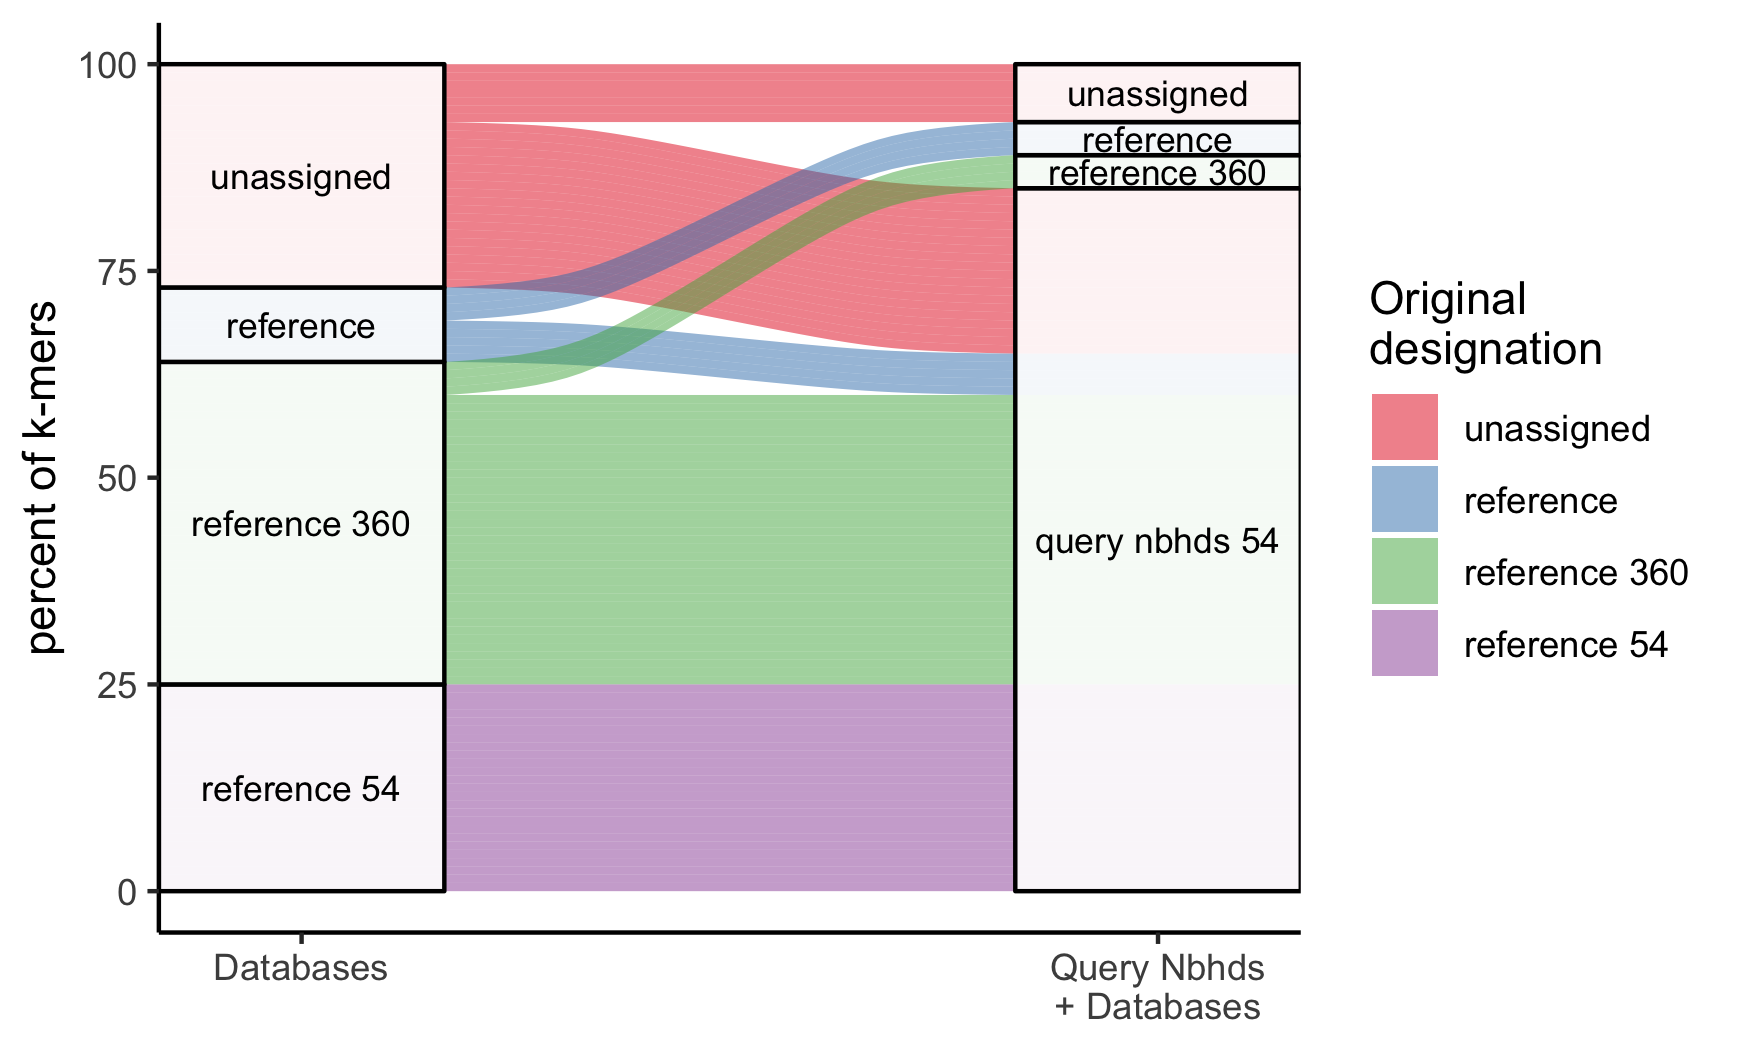

In [27]:
# adjust plot size rendered inline
options(repr.plot.width = 5.8, repr.plot.height = 3.5, repr.plot.res = 300)

#pdf("figures/alluvial_percent_of_hashes.pdf", height = 3.5, width = 5.8)
ggplot(all,
       aes(y = Freq, axis1 = GTDB, axis2 = After)) +
  geom_alluvium(aes(fill = GTDB)) +
  #geom_stratum(width = 1/12, fill = "black", color = "grey") +
  #geom_label(stat = "stratum", aes(label = after_stat(stratum))) +
  geom_stratum(alpha = .9) +
  geom_text(stat = "stratum", size = 3, aes(label = after_stat(stratum))) +
  scale_x_discrete(limits = c("Databases", "Query Nbhds\n+ Databases"), expand = c(.05, .05)) +
  scale_fill_brewer(type = "qual", palette = "Set1")  +
  theme_classic() +
  theme(panel.background = element_rect(fill = "transparent", colour = NA),  
        plot.background = element_rect(fill = "transparent", colour = NA),
        legend.background = element_rect(fill = "transparent", color = NA)) +
  labs(y = "percent of k-mers", fill = "Original\ndesignation")
#dev.off()